# Modeling Notebook with Balanced Dataset

# Importing Packages

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score

import re
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS


%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *
from preprocess import *


In [2]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))
test = pickle.load(open("../pickle/test_bal.pickle", "rb"))

In [5]:
train.target.value_counts()

1    22290
0    22290
Name: target, dtype: int64

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [8]:
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    tweets_p = []
    for i in tokenized_tweet:
        t = ' '.join(i)
        tweets_p.append(t)
    return tweets_p
    

In [12]:
train.tweet = preprocess(train.tweet)   
train.head()
train.target.value_counts()
val.tweet = preprocess(val.tweet)   
val.head()
test.tweet=preprocess(test.tweet) 
test.head()


,tweet,target
0,spoti perhap murrayhat would happier murray bi...,1
1,might libtard libtard sjw liber polit,1
2,korean amp joseon peopl japan abus claim right...,1
3,ny develop racist deathwish,1
4,fascism arriv nazi salut sharp suit altright r...,1


# Modeling

In [14]:
X_tr = train.tweet.values
X_val = val.tweet.values
y_tr = train.target.values
y_val = val.target.values
vec = TfidfVectorizer()
# X_tr= 
tfidf_tr = vec.fit_transform([str(item) for item in X_tr])
tfidf_val = vec.transform([str(item) for item in X_val])


In [15]:
tfidf_tr1=vec.fit_transform(X_tr)
tfidf_tr1.shape

(44580, 26305)

In [16]:
# X_tr1=X_tr.split('\n')
# y_tr1=y_tr.split('\n')
[str(item) for item in X_tr]

['latest indigen remot daili thank justjust',
 'video whole situat boycottdelta expo truth fraud adamsaleh delta prankster',
 'trump associ classi bunch',
 'peopl like come term like terrorist asshol',
 'black men black women stockholm syndrom',
 'allahsoil term jihad highli contest concept teambt teamsuperjunior',
 'nick cannon speak system via alllivesmatt unbornlivesmatt',
 'famili horribl attack thegreenpalmcottag plettenburgbay westerncap thyini thiza want',
 'dare accur poray treasonoustrump china next say fascist lapdog putin',
 'dear versac wont buy yur retail sign pissedoffitalian',
 'icymi complet washout anti racism chang antirac',
 'hire graduat taught amp genocid',
 'truth abt polic amp maga audiblechannel',
 'give white nationalist troll platform spread hate read buy boo',
 'basic sum brexit mean britain euroscept xenophob isolationist tribal',
 'allahsoil greenspan polici larg blame mogag crisi',
 'defund aboion send inaugur',
 'almost alway trust brazilian',
 'femin equ

In [17]:
pickle.dump(vec, open("../pickle/vec.pickle", "wb"))

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def get_metrics(X, y, y_pred, model):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    
    
    print('Accuracy: ', acc)
    print('F1: ', f1)
    print('Recall: ', rec)
    print('Precision: ', prec)
   

def get_confusion(y, y_pred):
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

In [20]:
train.target.value_counts()

1    22290
0    22290
Name: target, dtype: int64

## Multinomial Naive Bayes Model

Accuracy:  0.9438088829071333
F1:  0.945714595297432
Recall:  0.9789143113503813
Precision:  0.9146929364913016


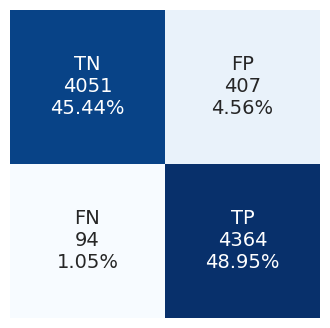

In [21]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_nb_val, nb)
get_confusion(y_val,y_pr_nb_val)

## Random Forest Classifier

Accuracy:  0.9826155226558995
F1:  0.9828368951389659
Recall:  0.9955136832660386
Precision:  0.9704788978788541


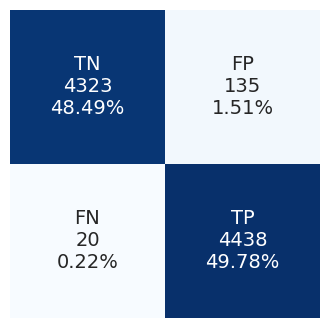

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(tfidf_tr, y_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_rf_val, rf)
get_confusion(y_val,y_pr_rf_val)

## Logistic Regression

Accuracy:  0.9700538358008075
F1:  0.970487454404775
Recall:  0.9847465231045311
Precision:  0.9566354325561125


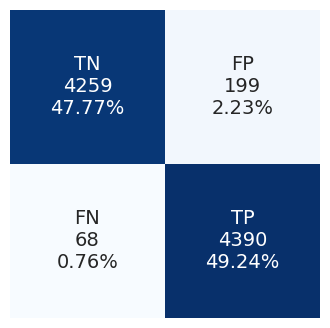

In [23]:
model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=42)
log = model.fit(tfidf_tr, y_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_log_val, log)
get_confusion(y_val,y_pr_log_val)

## Support Vector Machine

Accuracy:  0.9798115746971736
F1:  0.9800796812749004
Recall:  0.9932705248990579
Precision:  0.9672346002621232


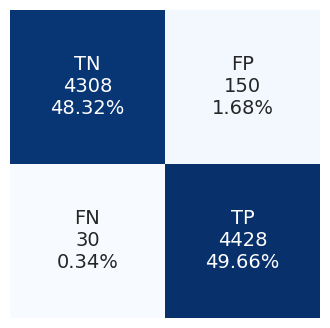

In [24]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pr_svc_val = svc.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_svc_val, svc)
get_confusion(y_val,y_pr_svc_val)

## AdaBoost Classifier

Accuracy:  0.8697846567967699
F1:  0.8633635400729669
Recall:  0.822790489008524
Precision:  0.9081455805892548


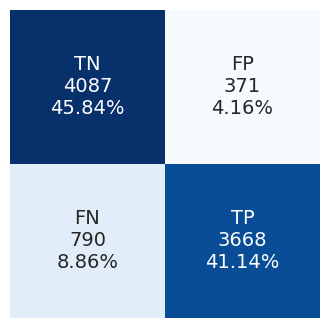

In [25]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    random_state=42
    ).fit(tfidf_tr, y_tr)
y_pr_abc_val = abc.predict(tfidf_val)
y_pr_svc_val
get_metrics(tfidf_val, y_val, y_pr_abc_val, abc)
get_confusion(y_val,y_pr_abc_val)

## Gradient Boosting

Accuracy:  0.8018169582772544
F1:  0.7703703703703704
Recall:  0.6648721399730821
Precision:  0.9156626506024096


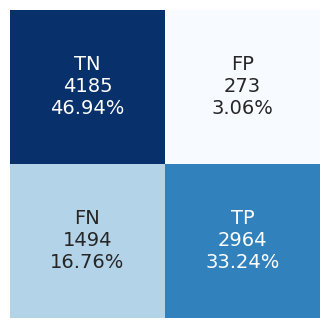

In [26]:
gbc = GradientBoostingClassifier(random_state=42).fit(tfidf_tr, y_tr)
y_pr_gbc_val = gbc.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_gbc_val, gbc)
get_confusion(y_val,y_pr_gbc_val)

## Metrics Dataframe

In [78]:
data = {'Accuracy': [accuracy_score(y_val, y_pr_nb_val), 
                     accuracy_score(y_val, y_pr_rf_val), 
                     accuracy_score(y_val, y_pr_log_val), 
                     accuracy_score(y_val, y_pr_svc_val),
                     accuracy_score(y_val, y_pr_abc_val),
                     accuracy_score(y_val, y_pr_gbc_val)],
        'F1 Score': [f1_score(y_val, y_pr_nb_val), 
                     f1_score(y_val, y_pr_rf_val), 
                     f1_score(y_val, y_pr_log_val), 
                     f1_score(y_val, y_pr_svc_val),
                     f1_score(y_val, y_pr_abc_val),
                     f1_score(y_val, y_pr_gbc_val)],
        'Recall': [recall_score(y_val, y_pr_nb_val), 
                   recall_score(y_val, y_pr_rf_val), 
                   recall_score(y_val, y_pr_log_val),
                   recall_score(y_val, y_pr_svc_val),
                   recall_score(y_val, y_pr_abc_val),
                   recall_score(y_val, y_pr_gbc_val)],
        'Precision': [precision_score(y_val, y_pr_nb_val), 
                      precision_score(y_val, y_pr_rf_val), 
                      precision_score(y_val, y_pr_log_val),
                      precision_score(y_val, y_pr_svc_val),
                      precision_score(y_val, y_pr_abc_val),
                      precision_score(y_val, y_pr_gbc_val)]
        }
metrics_on_validation_data = pd.DataFrame(data=data, index = ['Multinomial Naive Bayes', 
                                            'Random Forest',
                                            'Logistic Regression',
                                            'Support Vector Machine', 
                                            'AdaBoost Classifier', 
                                            'Gradient Boosting Classifier'])

# Metrics on validation Data

In [79]:
metrics_on_validation_data
metrics_on_validation_data.to_csv("../data/metrics/metrics_on_validation_data.csv")

In [80]:
metrics_on_validation_data

,Accuracy,F1 Score,Recall,Precision
Multinomial Naive Bayes,0.943809,0.945715,0.978914,0.914693
Random Forest,0.982616,0.982837,0.995514,0.970479
Logistic Regression,0.970054,0.970487,0.984747,0.956635
Support Vector Machine,0.979812,0.980080,0.993271,0.967235
AdaBoost Classifier,0.869785,0.863364,0.822790,0.908146
Gradient Boosting Classifier,0.801817,0.770370,0.664872,0.915663


In [ ]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(nb, file)


# Test Set (Final Evaluation)

In [28]:
X_tt = test.tweet
y_tt = test.target
tfidf_tt = vec.transform(X_tt)


In [31]:
y_pr_nb_tt = nb.predict(tfidf_tt)
y_pr_rf_tt = rf.predict(tfidf_tt)
y_pr_log_tt = log.predict(tfidf_tt)
y_pr_svc_tt = svc.predict(tfidf_tt)
y_pr_abc_tt = abc.predict(tfidf_tt)
y_pr_gbc_tt = gbc.predict(tfidf_tt)


Accuracy:  0.9404441453566622
F1:  0.9425138031828516
Recall:  0.9764468371467026
Precision:  0.9108600125549278


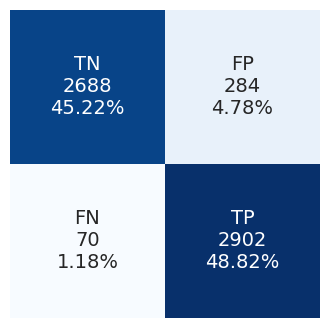

In [32]:
get_metrics(tfidf_tt, y_tt, y_pr_nb_tt, nb)
get_confusion(y_tt, y_pr_nb_tt)

Accuracy:  0.982671601615074
F1:  0.9829385456352494
Recall:  0.9983176312247645
Precision:  0.968026101141925


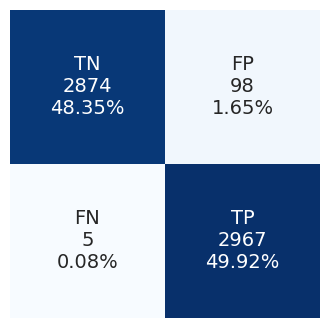

In [33]:
get_metrics(tfidf_tt, y_tt, y_pr_rf_tt, rf)
get_confusion(y_tt, y_pr_rf_tt)

Accuracy:  0.9658479138627187
F1:  0.9664739884393063
Recall:  0.9845222072678331
Precision:  0.9490755757379176


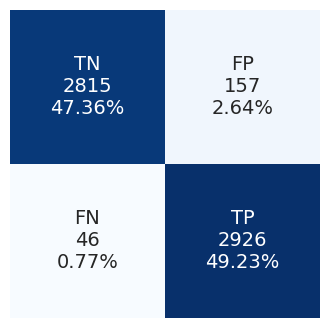

In [34]:
get_metrics(tfidf_tt, y_tt, y_pr_log_tt, log)
get_confusion(y_tt, y_pr_log_tt)

Accuracy:  0.9789703903095559
F1:  0.9792531120331951
Recall:  0.9925975773889637
Precision:  0.9662626924336718


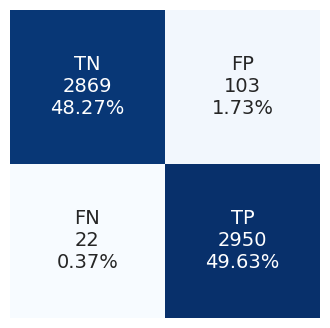

In [35]:
get_metrics(tfidf_tt, y_tt, y_pr_svc_tt, svc)
get_confusion(y_tt, y_pr_svc_tt)

Accuracy:  0.8605316285329744
F1:  0.853559441794736
Recall:  0.8129205921938089
Precision:  0.898475269616958


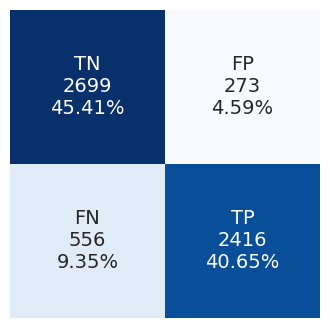

In [36]:
get_metrics(tfidf_tt, y_tt, y_pr_abc_tt, abc)
get_confusion(y_tt, y_pr_abc_tt)

Accuracy:  0.7971063257065949
F1:  0.7656432180334241
Recall:  0.6628532974427994
Precision:  0.906163753449862


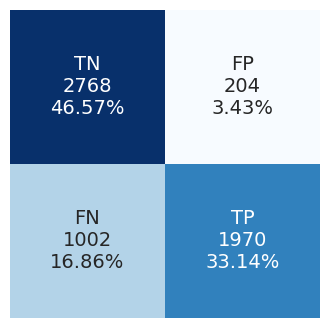

In [37]:
get_metrics(tfidf_tt, y_tt, y_pr_gbc_tt, gbc)
get_confusion( y_tt, y_pr_gbc_tt)

In [82]:
data6 = {'Accuracy': [accuracy_score(y_tt, y_pr_nb_tt), 
                      accuracy_score(y_tt, y_pr_rf_tt), 
                      accuracy_score(y_tt, y_pr_log_tt), 
                      accuracy_score(y_tt, y_pr_svc_tt),
                      accuracy_score(y_tt, y_pr_abc_tt),
                      accuracy_score(y_tt, y_pr_gbc_tt)],
        'F1 Score': [f1_score(y_tt, y_pr_nb_tt), 
                     f1_score(y_tt, y_pr_rf_tt), 
                     f1_score(y_tt, y_pr_log_tt), 
                     f1_score(y_tt, y_pr_svc_tt),
                     f1_score(y_tt, y_pr_abc_tt),
                     f1_score(y_tt, y_pr_gbc_tt)],
        'Recall': [recall_score(y_tt, y_pr_nb_tt), 
                   recall_score(y_tt, y_pr_rf_tt), 
                   recall_score(y_tt, y_pr_log_tt),
                   recall_score(y_tt, y_pr_svc_tt),
                   recall_score(y_tt, y_pr_abc_tt),
                   recall_score(y_tt, y_pr_gbc_tt)],
        'Precision': [precision_score(y_tt, y_pr_nb_tt), 
                      precision_score(y_tt, y_pr_rf_tt), 
                      precision_score(y_tt, y_pr_log_tt),
                      precision_score(y_tt, y_pr_svc_tt),
                      precision_score(y_tt, y_pr_abc_tt),
                      precision_score(y_tt, y_pr_gbc_tt)]
        }
metrics_on_testing_data = pd.DataFrame(data=data6, index = ['Multinomial Naive Bayes', 
                                             'Random Forest',
                                             'Logistic Regression',
                                             'Support Vector Machine', 
                                             'AdaBoost Classifier', 
                                             'Gradient Boosting Classifier'])

# Metrics on test data

In [83]:
metrics_on_testing_data.to_csv("../data/metrics/metrics_on_testing_data.csv")
metrics_on_testing_data

,Accuracy,F1 Score,Recall,Precision
Multinomial Naive Bayes,0.940444,0.942514,0.976447,0.910860
Random Forest,0.982672,0.982939,0.998318,0.968026
Logistic Regression,0.965848,0.966474,0.984522,0.949076
Support Vector Machine,0.978970,0.979253,0.992598,0.966263
AdaBoost Classifier,0.860532,0.853559,0.812921,0.898475
Gradient Boosting Classifier,0.797106,0.765643,0.662853,0.906164


# Hyperparameters Tuning

## Logistic Regression

In [40]:
# logreg = LogisticRegression(random_state=42)
logreg=model
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
gslog = GridSearchCV(estimator = logreg,
                     param_grid = params,
                     cv = 10,
                     n_jobs = -1, 
                     verbose=3).fit(tfidf_tr, y_tr)
y_pred_gslog = gslog.predict(tfidf_val)
print("Best: %f using %s" % (gslog.best_score_, gslog.best_params_))

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Best: 0.985734 using {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


Accuracy:  0.9816061013907582
F1:  0.9818020417221482
Recall:  0.9923732615522656
Precision:  0.971453667105841


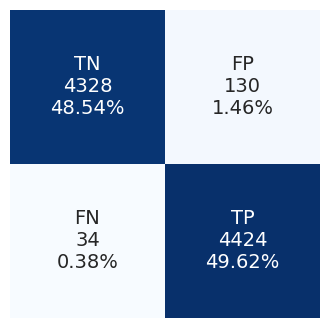

In [44]:
get_metrics(tfidf_val, y_val, y_pred_gslog, gslog)
get_confusion(y_val, y_pred_gslog)


Accuracy:  0.9803723642889188
F1:  0.9806480150392569
Recall:  0.9946164199192463
Precision:  0.9670665212649946


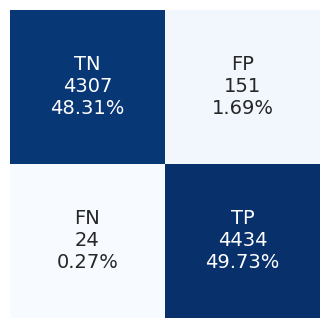

In [45]:
log_best = LogisticRegression(random_state=42, 
                              C=10, 
                              penalty='l2', 
                              solver='lbfgs').fit(tfidf_tr, y_tr)
y_pred_log_best = log_best.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred_log_best, log_best)
get_confusion(y_val, y_pred_log_best)

Accuracy:  0.9776244952893675
F1:  0.9779910640410393
Recall:  0.9942799461641992
Precision:  0.9622272875284924


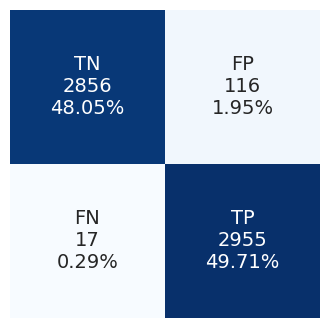

In [46]:
y_pred_log_best = log_best.predict(tfidf_tt)
get_metrics(tfidf_tt, y_tt, y_pred_log_best, log_best)
get_confusion(y_tt, y_pred_log_best)

In [47]:
pickle.dump(log_best, open("../pickle/log_best.pickle", "wb"))

In [48]:
pickle_model = pickle.load(open("../pickle/log_best.pickle", 'rb'))

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [500, 1000, 2000, 5000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.904793 using {'n_estimators': 1000}


In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [1000],
          'max_depth': [1500],
          'min_samples_leaf': [1, 2, 4]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.904793 using {'max_depth': 1500, 'min_samples_leaf': 1, 'n_estimators': 1000}


In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [1000],
          'max_depth': [1500],
          'min_samples_leaf': [1],
          'min_samples_split': [2, 5, 10]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.905276 using {'max_depth': 1500, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}


In [69]:
rfc_best = RandomForestClassifier(random_state=42, 
                                  max_depth=1500, 
                                  min_samples_leaf=1,
                                  min_samples_split=5, 
                                  n_estimators=1000).fit(tfidf_tr, y_tr)
y_pred_rfc_best = rfc_best.predict(tfidf_val)

Accuracy:  0.9882957465029975
F1:  0.9881878421204263
Recall:  0.9791607193833857
Precision:  0.997382960162838


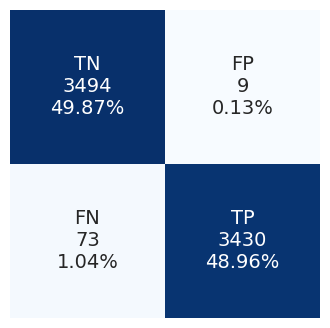

In [70]:
get_metrics(tfidf_val, y_val, y_pred_rfc_best, rfc_best)
get_confusion(y_val,y_pred_rfc_best)

Accuracy:  0.7193921232876712
F1:  0.7775326658747667
Recall:  0.980736301369863
Precision:  0.6440820916502671


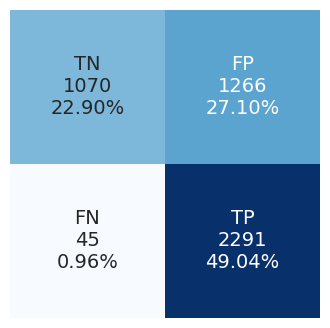

In [71]:
y_pred_rfc_best = rfc_best.predict(tfidf_tt)
get_metrics(tfidf_tt, y_tt, y_pred_rfc_best, rfc_best)
get_confusion(y_tt,y_pred_rfc_best)

## Support Vector Machine

In [47]:
from sklearn.svm import SVC
svm = SVC()
params_grid = {'C': [0.1, 1, 10, 100]}
gssvm = GridSearchCV(SVC(),
                     params_grid,
                     refit = True,
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.990236 using {'C': 100}


In [57]:
svm = SVC()
params_grid = {'C': [10],
               'gamma': [0.1],
               'kernel': ['rbf', 'poly', 'sigmoid']}
gssvm = GridSearchCV(SVC(),
                     params_grid, 
                     refit = True, 
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.964571 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


# Accuracy test on validation set at C=10

Accuracy:  0.9788021534320323
F1:  0.9790488859328234
Recall:  0.990578734858681
Precision:  0.967784352399737


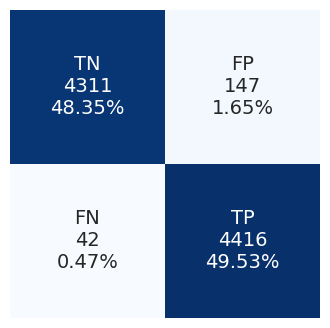

In [51]:
from sklearn.svm import SVC
svm = SVC()
svm_best = SVC(C=10, gamma=0.1, kernel='sigmoid').fit(tfidf_tr, y_tr)
y_pred_svm_best = svm_best.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred_svm_best, svm_best)
get_confusion(y_val, y_pred_svm_best)

# Metrics on test set at C=10

Accuracy:  0.9771197846567967
F1:  0.9774236387782205
Recall:  0.990578734858681
Precision:  0.9646133682830931


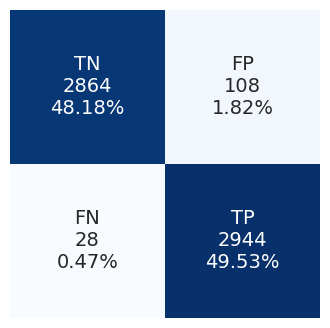

In [53]:
svm_best = SVC(C=10, gamma=0.1, kernel='sigmoid').fit(tfidf_tr, y_tr)
y_pred_svm_best = svm_best.predict(tfidf_tt)
get_metrics(tfidf_tt, y_tt, y_pred_svm_best, svm_best)
get_confusion(y_tt, y_pred_svm_best)

# Metrics on test set at C=100

Accuracy:  0.9779609690444145
F1:  0.9782788923893219
Recall:  0.9925975773889637
Precision:  0.9643674403399803


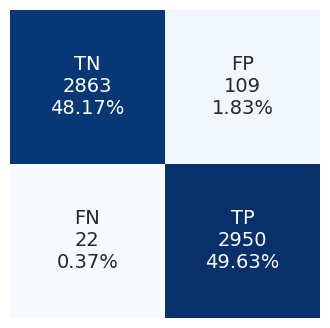

In [62]:
svm_best = SVC(C=100, gamma=0.1, kernel='sigmoid').fit(tfidf_tr, y_tr)
y_pred_svm_best = svm_best.predict(tfidf_tt)
get_metrics(tfidf_tt, y_tt, y_pred_svm_best, svm_best)
get_confusion(y_tt, y_pred_svm_best)

In [63]:
import pickle
pickle.dump(svm_best, open("../pickle/svm_best.pickle", "wb"))
pickle_model = pickle.load(open("../pickle/svm_best.pickle", 'rb'))
# with open('../pickle/svm_best.pickle', 'wb') as f:
#     pickle.dump(svm_best, f, pickle.HIGHEST_PROTOCOL)

In [64]:
data7 = {'Accuracy': [accuracy_score(y_tt, y_pred_log_best),
                     #  accuracy_score(y_tt, y_pred_rfc_best),
                      accuracy_score(y_tt, y_pred_svm_best)],
        'F1 Score': [f1_score(y_tt, y_pred_log_best),
                     # f1_score(y_tt, y_pred_rfc_best),
                     f1_score(y_tt, y_pred_svm_best)],
        'Recall': [recall_score(y_tt, y_pred_log_best),
              #      recall_score(y_tt, y_pred_rfc_best),
                   recall_score(y_tt, y_pred_svm_best)],
        'Precision': [precision_score(y_tt, y_pred_log_best),
                     #  precision_score(y_tt, y_pred_rfc_best),
                      precision_score(y_tt, y_pred_svm_best)]
       }
metrics7 = pd.DataFrame(data=data7, index=['Logistic Regression w/GridsearchCV',
                                          #  'Random Forest w/GridsearchCV',
                                           'Support Vector Machine w/GridsearchCV'])

# Metrics on validation data after HyperParameter Tuning

In [65]:
metrics7

,Accuracy,F1 Score,Recall,Precision
Logistic Regression w/GridsearchCV,0.977624,0.977991,0.994280,0.962227
Support Vector Machine w/GridsearchCV,0.977961,0.978279,0.992598,0.964367


In [67]:
metrics7.to_csv("../data/metrics/metrics_after_hyperparameter_tuning.csv")